# Plot the full forcing from albedo and Phum one map and over time 
# for FULL runs 
## Used for
    - hom_P-2Pr

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib import gridspec
fs=20 #fontsize for labels, legend, ...
font={'family' : 'serif', 'size' : fs} #define font for legend
plt.rc('font', **font)
import cmocean
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap
# import via conda install basemap (for some reason pip doesnt work)

/home/peter/anaconda2/lib/python2.7/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


KeyError: 'PROJ_LIB'

In [2]:
climber_path='/home/peter/PIK/climber/' #/home/peter/PIK/climber/

In [3]:
ref=[]
refname="hom_REF"
p=[]
runname="hom_P-2Pr"

long_years=np.arange(54863, 55104, step=10)
years=long_years-54983+2010
for y in long_years:
    ref.append(xr.open_dataset(
        climber_path+"/cluster_results/data_Mai8files/"+"c3beta_anthrHeat_"+refname+'/snaps/'+
        "snapshots_potsdam2.0"+str(y)+".01.01.dta.nc", decode_times=False))
    p.append(xr.open_dataset(
        climber_path+"/cluster_results/data_Mai8files/"+"c3beta_anthrHeat_"+runname+'/snaps/'+
        "snapshots_potsdam2.0"+str(y)+".01.01.dta.nc", decode_times=False))
X,Y = np.meshgrid(np.insert(ref[0].xu_i,0,0), ref[0].yu_j)
x,y=np.meshgrid(ref[0].xt_i, ref[0].yt_j)


In [4]:
def area_mean_lon(x, lats=ref[0].yt_j, lon=ref[0].xt_i):
    '''x should have dimensions: lat,lon'''
    weights=np.cos(lats*np.pi/180)
    irrelevant,real_weights=np.meshgrid(lon, weights)
    z=real_weights*x
    return np.sum(z)/np.sum(real_weights)

In [5]:
def change_to_Atl(x, grid=p[1]):
    new_x=np.copy(x)
    #print(np.shape(new_x))
    switch=np.where(grid.xt_i>180)[0][0]
    for i in range(0,len(grid.xt_i)):
        if grid.xt_i[i]>180:
            new_x[:,i-switch]=x[:,i]
            #print(i-switch)
        else:
            new_x[:,i+switch]=x[:,i]
            #print(i+switch)
    return new_x
#frlnd_atl=change_to_Atl(p[-1].frlnd[0])
X_atl=X-180
Y_atl=Y

In [6]:
diff_as=[]
for n,i in enumerate(years):
    diff_as.append(p[n].data_vars['as'].mean(dim="Time")-ref[n].data_vars['as'].mean(dim="Time"))
diff_as=np.array(diff_as)

In [7]:
diff_T=[] # surface air temperatures (mean)
for n,i in enumerate(years):
    diff_T.append(p[n].data_vars['ts'].mean(dim='Time')-ref[n].data_vars['ts'].mean(dim='Time'))
diff_T=np.array(diff_T)

In [8]:
flat_diff_as=diff_as[-1].flatten()
flat_diff_T=diff_T[-1].flatten()


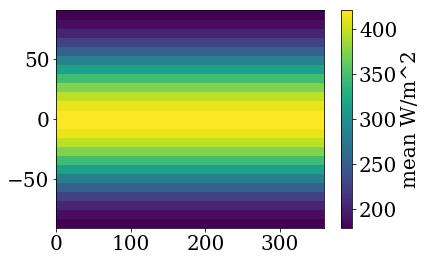

In [9]:
def get_S_field():
        # solar insolation (gridpoints x) in W/m^2
        return 1361./4*(1-0.477*0.5*(3*np.sin(y*np.pi/180)**2-1))
S=get_S_field()
plt.pcolormesh(X,Y,S)
plt.colorbar(label="mean W/m^2")

# Forcing Map:

In [10]:
P_folder="txt_file_each_yearJul13_11-20"
addendum=""

P=[]
for y in years:
    if y>2010:
        P.append(ref[0].frlnd[0] * 1.02**(y-2010)*np.loadtxt(
            "../data_preparation/PMIP/P_hum/"+P_folder+"/P_hum_"+addendum+"year2010.dat"))
    else:
        P.append(ref[0].frlnd[0] * np.loadtxt(
            "../data_preparation/PMIP/P_hum/"+P_folder+"/P_hum_"+addendum+"year"+str(y)+".dat"))
      

NameError: name 'Basemap' is not defined

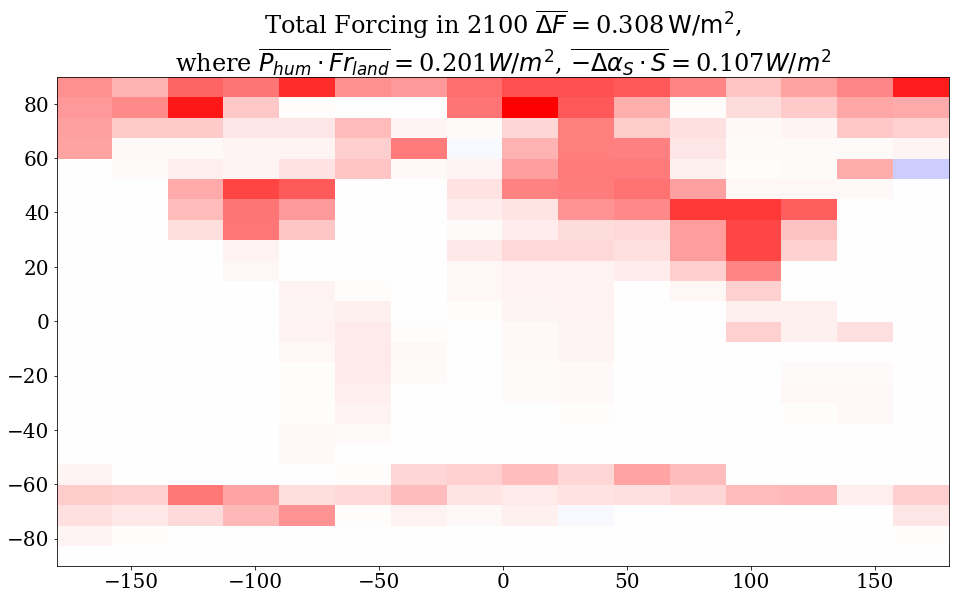

In [13]:
y=2100
ind=np.where(years==y)[0][0]
forcing=P[:]-S*diff_as[:]
fig=plt.figure(figsize=(16,9))
ax=fig.add_subplot(111)
ax.set_title("Total Forcing in "+str(y)+" $\overline{\Delta F}=$"+'%.3f' % area_mean_lon(forcing[ind])+r"$\, {\rm W/m^2}$,"+
             '\n'+r"where $\overline{P_{hum}\cdot Fr_{land}}=$"+'%.3f' % area_mean_lon(P[ind])+"$W/m^2$"+
             r", $\overline{-\Delta \alpha_S\cdot S}=$"+'%.3f' % area_mean_lon(-S*diff_as[ind])+"$W/m^2$")
scale=np.max(abs(forcing[ind]))
plot=ax.pcolormesh(X_atl, Y_atl, change_to_Atl(forcing[ind]), vmin=-scale, vmax=scale, cmap='bwr')
m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
m.drawcoastlines()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=0.05)
cb=plt.colorbar(plot, cax=cax, label=r'$\Delta F = P_{hum} \cdot Fr_{land}-\Delta \alpha_S \cdot S(\theta)$ in $W/m^2$')
#print(area_mean_lon(forcing))

In [14]:
mean_forcing=[]
mean_P=[]
mean_da_S=[]
for f in forcing:
    mean_forcing.append(area_mean_lon(f))
for p in P:
    mean_P.append(area_mean_lon(p))
for a in diff_as:
    mean_da_S.append(area_mean_lon(a*S))
mean_forcing=np.array(mean_forcing)
mean_P=np.array(mean_P)
mean_da_S=np.array(mean_da_S)

np.shape(mean_da_S)

(25,)

### Load Ocean

In [15]:
def get_time(y):
    return (y+54783-1-1810)*360-0.5
def get_year(t):
    return (t+0.5)/360 +1810+1-54783
    #return (t+54783-1-1810)*360-0.5

In [16]:
mainfolder=climber_path+"cluster_results/data_Mai8files/"
oc_reffolder=mainfolder
oc_refname="hom_REF" 
oc_folder_ref=oc_reffolder+"c3beta_anthrHeat_"+oc_refname+'/'
oc_data_ref= xr.open_dataset(oc_folder_ref+"history_short.nc", decode_times=False)

oc_runname="hom_P-2Pr"
oc_folder_p=mainfolder+"c3beta_anthrHeat_"+oc_runname+'/'
oc_data_p= xr.open_dataset(oc_folder_p+"history_short.nc", decode_times=False)

In [17]:
ind=np.where(oc_data_ref.Time == get_time(2100))
print("World Ocean Heat Uptake in 2100: ", 
      oc_data_p.hflx_ave[ind].values*41867.28072 - oc_data_ref.hflx_ave[ind].values*41867.28072 )
oc_heat_uptake=[]
for y in years:
    ind=np.where(oc_data_ref.Time == get_time(y))
    oc_heat_uptake.append(
        oc_data_p.hflx_ave[ind].values[0]*41867.28072 - oc_data_ref.hflx_ave[ind].values[0]*41867.28072 )


('World Ocean Heat Uptake in 2100: ', array([0.07573462], dtype=float32))


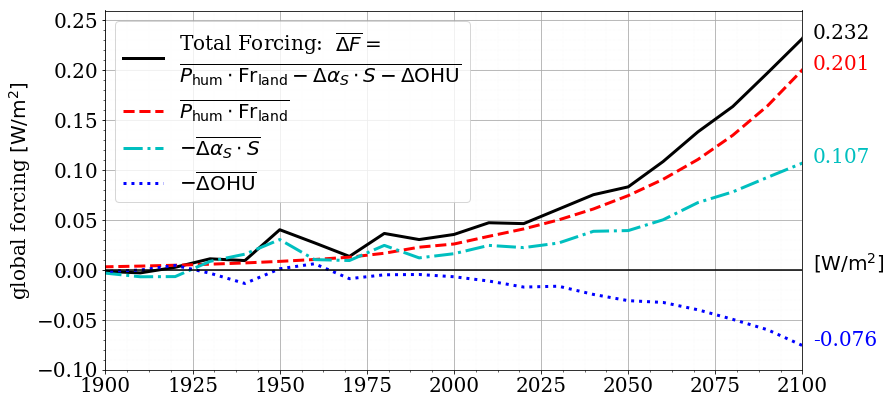

In [31]:
fig=plt.figure(figsize=(12,6))
ax=fig.add_subplot(111)
ax.plot(years, mean_forcing-oc_heat_uptake, '-', color='black', label=r'Total Forcing:  $\overline{\Delta F}= $'
        +'\n'+r'$\overline{P_{\rm hum}\cdot {\rm Fr}_{\rm land}- \Delta \alpha_S \cdot S - \Delta {\rm OHU}}$', lw=3)
#ax.plot(years, exp(years, *popt), ':', color='black', label="exp. fit: ")
ax.plot(years, mean_P, '--', color='red', label=r'$\overline{P_{\rm hum}\cdot {\rm Fr}_{\rm land}}$', lw=3)
ax.plot(years, -mean_da_S,  '-.', color='c', label=r'$-\overline{ \Delta \alpha_S \cdot S}$', lw=3)
ax.plot(years, -np.array(oc_heat_uptake), ':', color='blue', label=r'$-\overline{ \Delta {\rm OHU}}$', lw=3)
ax.set_ylim(-0.1, 0.26)
ax.axhline(y=0, color='black')
ax.tick_params(axis='y', which='minor', bottom='off')
ax.minorticks_on()
ax.grid(which='major', color='darkgrey')
ax.grid(which='minor', color='lightgrey', lw=0.1, ls=':')
ax.set_ylabel(r"global forcing $[{\rm W/m^2}]$")
ax.legend(loc='best', fontsize=20)
ax.set_xlim(1900, 2100)
textyear=2103
fs=20
numberyear=np.where(years==ax.get_xlim()[1])[0][0]
ax.text(textyear, (mean_forcing-oc_heat_uptake)[numberyear],  '%.3f' % ((mean_forcing-oc_heat_uptake)[numberyear]), fontsize=fs, color='black')
ax.text(textyear, mean_P[numberyear],  '%.3f' % (mean_P[numberyear]), fontsize=fs, color='red')
ax.text(textyear, -mean_da_S[numberyear],  '%.3f' % (-mean_da_S[numberyear]), fontsize=fs, color='c')
ax.text(textyear, -oc_heat_uptake[numberyear],  '%.3f' % (-oc_heat_uptake[numberyear]), fontsize=fs, color='blue')
ax.text(textyear, 0.,  r"$[{\rm W/m^2}]$", fontsize=fs)
fig.tight_layout()
plt.savefig("tot_forcing"+runname+".eps", format='eps', bbox_inches='tight')

In [22]:
numberyear

2100.0

In [99]:
#plt.plot(-mean_da_S/mean_forcing)
#plt.ylim(0.15,0.5)
#plt.grid()

In [15]:
#0.096*1.3

0.12480000000000001